In [81]:
#previosuly when I looked at ice mask (in week 5), the SVM performed quite poorly on the floating ice category. 
#bing suggested that I improve this by treating it as an unbalanced data problem, adjusting the behaviour of 
#the model to consider the less seen category as more important.
#these updates are what I will do in this file 

import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

original_ice_mask = pd.read_csv('../data/AIS-86Year/vars_all_v2/vars-2015.txt', delimiter = '\t',
                      names=["x-axis", "y-axis", "ice_thickness", "ice_velocity", "ice_mask", 
                             "precipitation", "air_temp", "ocean_temp"])

#shifting the columns so the target is the one furthest to the right -> needed for scaling to avoid scaling ice mask
original_ice_mask = original_ice_mask[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp','ice_mask']]

#removing fill values in ocean temp, for a fair comparison to the EF data
tolerance = 1e+30
original_ice_mask = original_ice_mask[(original_ice_mask['ocean_temp'] < (9.969210e+36 - tolerance))]


#method to normalise the data -> scale each column between 0 and 1 
def scale (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns[:-1]:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df

def unscale_rmse(scaled_rmse, target_name, original_df):
    target_min = original_df[target_name].min()
    target_max = original_df[target_name].max()

    return scaled_rmse * (target_max - target_min)

#df = scale(df)
original_ice_mask.head()

,x-axis,y-axis,precipitation,air_temp,ocean_temp,ice_mask
14,-1337600,3040000,546.317932,266.901917,272.842255,4
15,-1216000,3040000,525.335876,266.538788,272.781281,4
16,-1094400,3040000,515.289246,266.182617,272.733276,4
17,-972800,3040000,506.943146,265.830536,272.698181,4
18,-851200,3040000,501.923645,265.492554,272.672577,4


In [82]:
EF_ice_mask = pd.read_csv('../data/AIS_data/EF_ice_mask.csv')
EF_ice_mask = EF_ice_mask[['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist', 
                           'temp_diff', 'air_roll', 'ocean_roll', 'precip_roll', 'ice_mask']]

EF_ice_mask.head()

,x-axis,y-axis,precipitation,air_temp,ocean_temp,dist,temp_diff,air_roll,ocean_roll,precip_roll,ice_mask
0,-1337600,3040000,546.317932,266.901917,272.842255,3.321261e+06,5.940338,266.796100,272.832892,539.069800,4
1,-1216000,3040000,525.335876,266.538788,272.781281,3.274180e+06,6.242493,266.467672,272.784983,529.967082,4
2,-1094400,3040000,515.289246,266.182617,272.733276,3.230992e+06,6.550659,266.087585,272.738302,519.236791,4
3,-972800,3040000,506.943146,265.830536,272.698181,3.191855e+06,6.867645,265.719961,272.704402,512.236516,4
4,-851200,3040000,501.923645,265.492554,272.672577,3.156920e+06,7.180023,265.400111,272.684906,508.556992,4


In [83]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

def doLinearSVC(preprocessed_df, seed, n_runs):
    overall_accuracies = []
    training_accuracies = []
    coefficients = []
    category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}
    training_category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        model = SVC(kernel='linear', random_state=randomState, class_weight = 'balanced')
        model.fit(X_train, y_train)
        
        coefficients.append(model.coef_[0])

        # Test data evaluation
        y_predicted = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_predicted)
        overall_accuracies.append(test_accuracy)
        
        test_cm = confusion_matrix(y_test, y_predicted, labels=[2.0, 3.0, 4.0])
        category_accuracies['grounded_ice'].append(test_cm[0, 0] / test_cm[0, :].sum() if test_cm[0, :].sum() > 0 else 0)
        category_accuracies['floating_ice'].append(test_cm[1, 1] / test_cm[1, :].sum() if test_cm[1, :].sum() > 0 else 0)
        category_accuracies['open_ocean'].append(test_cm[2, 2] / test_cm[2, :].sum() if test_cm[2, :].sum() > 0 else 0)

        # Training data evaluation
        y_train_predicted = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predicted)
        training_accuracies.append(train_accuracy)

        train_cm = confusion_matrix(y_train, y_train_predicted, labels=[2.0, 3.0, 4.0])
        training_category_accuracies['grounded_ice'].append(train_cm[0, 0] / train_cm[0, :].sum() if train_cm[0, :].sum() > 0 else 0)
        training_category_accuracies['floating_ice'].append(train_cm[1, 1] / train_cm[1, :].sum() if train_cm[1, :].sum() > 0 else 0)
        training_category_accuracies['open_ocean'].append(train_cm[2, 2] / train_cm[2, :].sum() if train_cm[2, :].sum() > 0 else 0)

    # Calculate averages and standard deviations
    average_accuracy = np.mean(overall_accuracies)
    std_accuracy = np.std(overall_accuracies)
    average_training_accuracy = np.mean(training_accuracies)
    std_training_accuracy = np.std(training_accuracies)
    average_coefficients = np.mean(coefficients, axis=0)
    std_coefficients = np.std(coefficients, axis=0)

    average_category_accuracies = {k: np.mean(v) for k, v in category_accuracies.items()}
    std_category_accuracies = {k: np.std(v) for k, v in category_accuracies.items()}
    average_training_category_accuracies = {k: np.mean(v) for k, v in training_category_accuracies.items()}
    std_training_category_accuracies = {k: np.std(v) for k, v in training_category_accuracies.items()}

    # Print average and standard deviation of accuracies
    print(f"Average Training Accuracy: {average_training_accuracy:.3f}, Std: {std_training_accuracy:.3f}")
    print("Training Category Metrics:")
    for category in training_category_accuracies:
        print(f"  {category}: Avg: {average_training_category_accuracies[category]:.3f}, Std: {std_training_category_accuracies[category]:.3f}") 

    print(f"\nAverage Test Accuracy: {average_accuracy:.3f}, Std: {std_accuracy:.3f}")
    print("Test Category Metrics:")
    for category in category_accuracies:
        print(f"  {category}: Avg: {average_category_accuracies[category]:.3f}, Std: {std_category_accuracies[category]:.3f}")
    
    print("\nAverage Coefficients:", average_coefficients)
    print("Std of Coefficients:", std_coefficients)
    return average_coefficients, std_coefficients

In [84]:
#++++++++++++++++++++++++++++++++++++++++++SVM LINEAR CLASSIFICATION++++++++++++++++++++++++++++++++++++++++++++++
seed = 101
scaled_df = scale(original_ice_mask)

svm_coefficients, std_coefficients = doLinearSVC(scaled_df, seed, 30)

Average Training Accuracy: 0.823, Std: 0.028
Training Category Metrics:
  grounded_ice: Avg: 0.644, Std: 0.016
  floating_ice: Avg: 0.918, Std: 0.030
  open_ocean: Avg: 0.987, Std: 0.006

Average Test Accuracy: 0.820, Std: 0.024
Test Category Metrics:
  grounded_ice: Avg: 0.644, Std: 0.034
  floating_ice: Avg: 0.860, Std: 0.073
  open_ocean: Avg: 0.987, Std: 0.007

Average Coefficients: [-0.2617497   1.02219951 -2.27278391  4.28039518  1.31919149]
Std of Coefficients: [2.3760369  0.35018497 2.6561152  4.55072372 1.38608563]


In [85]:
#+++++++++++++++++++++++++++++++++++++++++EF SVM LINEAR CLASSIFICATION++++++++++++++++++++++++++++++++++++++++++++
seed = 101
scaled_df = scale(EF_ice_mask)

EF_coef, EF_coef_std = doLinearSVC(scaled_df, seed, 30)

Average Training Accuracy: 0.875, Std: 0.007
Training Category Metrics:
  grounded_ice: Avg: 0.708, Std: 0.017
  floating_ice: Avg: 0.962, Std: 0.020
  open_ocean: Avg: 0.982, Std: 0.005

Average Test Accuracy: 0.872, Std: 0.010
Test Category Metrics:
  grounded_ice: Avg: 0.708, Std: 0.033
  floating_ice: Avg: 0.902, Std: 0.060
  open_ocean: Avg: 0.981, Std: 0.007

Average Coefficients: [ 0.0913438   0.57882928 -2.29305313  1.91898702  0.24782557  1.66471212
 -2.01139531  1.41048859  0.72681153 -0.32212115]
Std of Coefficients: [1.56247911 0.20813916 1.57622291 2.15434091 0.74880442 0.80509849
 2.35649093 1.94378517 0.67564484 1.35328614]


In [86]:
##+++++++++++++++++++++++++++++++++++++++++++++++PLOTTING COEF+++++++++++++++++++++++++++++++++++++++++++++

def plot_coefficients(coef_df, std_dev, title):
    for column in coef_df.columns: 
        coef_df[column] = coef_df[column].abs()
            
    transposed_coef = coef_df.T
    transposed_coef.reset_index(inplace=True)
    transposed_coef.columns = ['Feature', 'Coefficient']
    plt.figure(figsize=(10, 6))
    plt.bar(transposed_coef['Feature'], transposed_coef['Coefficient'], color='skyblue')

    # Add error bars
    plt.errorbar(transposed_coef['Feature'], transposed_coef['Coefficient'], yerr=std_dev, fmt='o', color='black', capsize=5)

    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

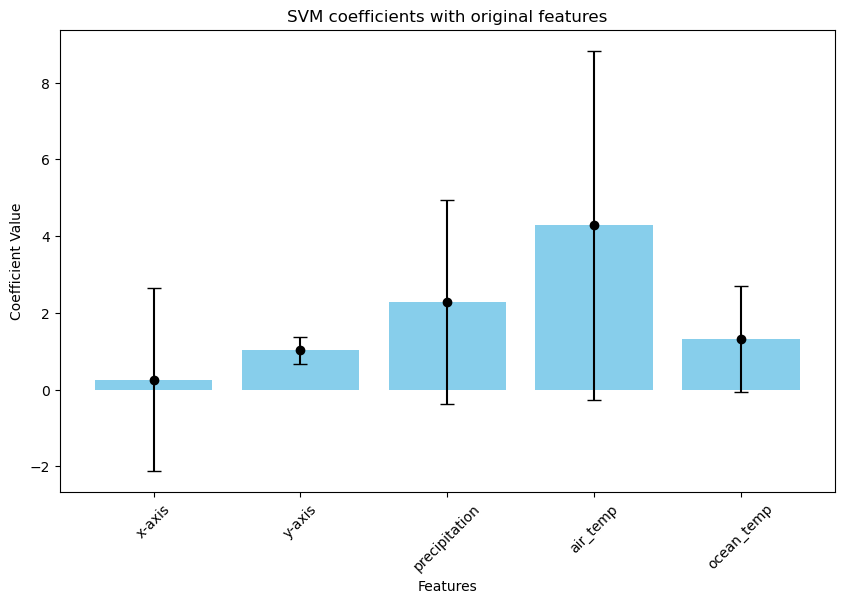

In [87]:
cols = ['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp']

svm_coefficients_df = pd.DataFrame([svm_coefficients], columns=cols)

plot_coefficients(svm_coefficients_df, std_coefficients, "SVM coefficients with original features")


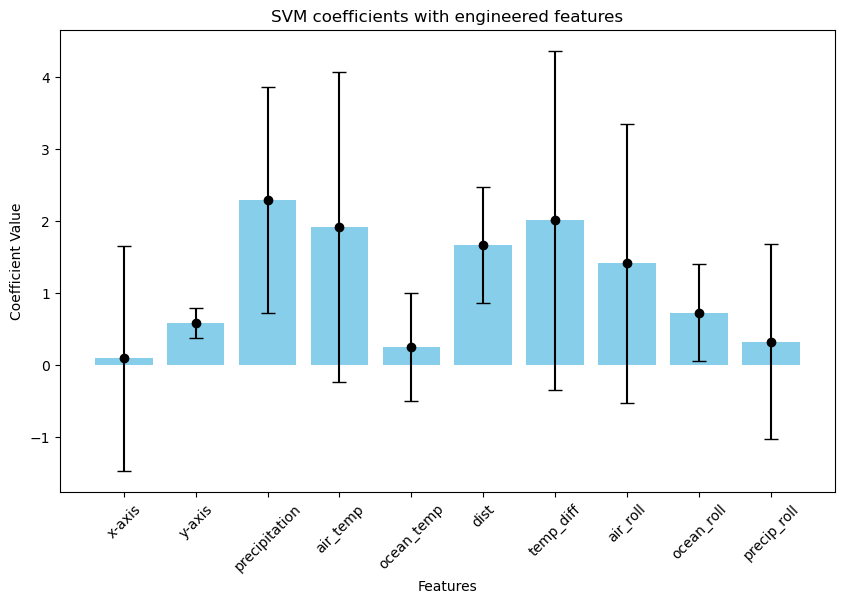

In [88]:
cols = ['x-axis', 'y-axis', 'precipitation', 'air_temp','ocean_temp', 'dist', 
                           'temp_diff', 'air_roll', 'ocean_roll', 'precip_roll']

EF_coefficients_df = pd.DataFrame([EF_coef], columns=cols)

plot_coefficients(EF_coefficients_df, EF_coef_std, "SVM coefficients with engineered features")


In [89]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

def doPolySVC(preprocessed_df, seed, n_runs):
    overall_accuracies = []
    training_accuracies = []
    category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}
    training_category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        model = SVC(kernel='poly', random_state=randomState, class_weight = 'balanced')
        model.fit(X_train, y_train)
        

        # Test data evaluation
        y_predicted = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_predicted)
        overall_accuracies.append(test_accuracy)
        
        test_cm = confusion_matrix(y_test, y_predicted, labels=[2.0, 3.0, 4.0])
        category_accuracies['grounded_ice'].append(test_cm[0, 0] / test_cm[0, :].sum() if test_cm[0, :].sum() > 0 else 0)
        category_accuracies['floating_ice'].append(test_cm[1, 1] / test_cm[1, :].sum() if test_cm[1, :].sum() > 0 else 0)
        category_accuracies['open_ocean'].append(test_cm[2, 2] / test_cm[2, :].sum() if test_cm[2, :].sum() > 0 else 0)

        # Training data evaluation
        y_train_predicted = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predicted)
        training_accuracies.append(train_accuracy)

        train_cm = confusion_matrix(y_train, y_train_predicted, labels=[2.0, 3.0, 4.0])
        training_category_accuracies['grounded_ice'].append(train_cm[0, 0] / train_cm[0, :].sum() if train_cm[0, :].sum() > 0 else 0)
        training_category_accuracies['floating_ice'].append(train_cm[1, 1] / train_cm[1, :].sum() if train_cm[1, :].sum() > 0 else 0)
        training_category_accuracies['open_ocean'].append(train_cm[2, 2] / train_cm[2, :].sum() if train_cm[2, :].sum() > 0 else 0)

    # Calculate averages and standard deviations
    average_accuracy = np.mean(overall_accuracies)
    std_accuracy = np.std(overall_accuracies)
    average_training_accuracy = np.mean(training_accuracies)
    std_training_accuracy = np.std(training_accuracies)

    average_category_accuracies = {k: np.mean(v) for k, v in category_accuracies.items()}
    std_category_accuracies = {k: np.std(v) for k, v in category_accuracies.items()}
    average_training_category_accuracies = {k: np.mean(v) for k, v in training_category_accuracies.items()}
    std_training_category_accuracies = {k: np.std(v) for k, v in training_category_accuracies.items()}

    # Print average and standard deviation of accuracies
    print(f"Average Training Accuracy: {average_training_accuracy:.3f}, Std: {std_training_accuracy:.3f}")
    print("Training Category Metrics:")
    for category in training_category_accuracies:
        print(f"  {category}: Avg: {average_training_category_accuracies[category]:.3f}, Std: {std_training_category_accuracies[category]:.3f}") 

    print(f"\nAverage Test Accuracy: {average_accuracy:.3f}, Std: {std_accuracy:.3f}")
    print("Test Category Metrics:")
    for category in category_accuracies:
        print(f"  {category}: Avg: {average_category_accuracies[category]:.3f}, Std: {std_category_accuracies[category]:.3f}")
    


In [90]:
#+++++++++++++++++++++++++++++++++++++++++EF SVM POLY CLASSIFICATION++++++++++++++++++++++++++++++++++++++++++++
seed = 101
scaled_df = scale(EF_ice_mask)

doPolySVC(scaled_df, seed, 30)

Average Training Accuracy: 0.910, Std: 0.007
Training Category Metrics:
  grounded_ice: Avg: 0.800, Std: 0.019
  floating_ice: Avg: 0.974, Std: 0.016
  open_ocean: Avg: 0.976, Std: 0.006

Average Test Accuracy: 0.902, Std: 0.011
Test Category Metrics:
  grounded_ice: Avg: 0.798, Std: 0.027
  floating_ice: Avg: 0.832, Std: 0.057
  open_ocean: Avg: 0.975, Std: 0.009


In [93]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np

def doRbfSVC(preprocessed_df, seed, n_runs):
    overall_accuracies = []
    training_accuracies = []
    category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}
    training_category_accuracies = {'grounded_ice': [], 'floating_ice': [], 'open_ocean': []}

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)
        
        model = SVC(kernel='rbf', random_state=randomState, class_weight = 'balanced')
        model.fit(X_train, y_train)
        

        # Test data evaluation
        y_predicted = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_predicted)
        overall_accuracies.append(test_accuracy)
        
        test_cm = confusion_matrix(y_test, y_predicted, labels=[2.0, 3.0, 4.0])
        category_accuracies['grounded_ice'].append(test_cm[0, 0] / test_cm[0, :].sum() if test_cm[0, :].sum() > 0 else 0)
        category_accuracies['floating_ice'].append(test_cm[1, 1] / test_cm[1, :].sum() if test_cm[1, :].sum() > 0 else 0)
        category_accuracies['open_ocean'].append(test_cm[2, 2] / test_cm[2, :].sum() if test_cm[2, :].sum() > 0 else 0)

        # Training data evaluation
        y_train_predicted = model.predict(X_train)
        train_accuracy = accuracy_score(y_train, y_train_predicted)
        training_accuracies.append(train_accuracy)

        train_cm = confusion_matrix(y_train, y_train_predicted, labels=[2.0, 3.0, 4.0])
        training_category_accuracies['grounded_ice'].append(train_cm[0, 0] / train_cm[0, :].sum() if train_cm[0, :].sum() > 0 else 0)
        training_category_accuracies['floating_ice'].append(train_cm[1, 1] / train_cm[1, :].sum() if train_cm[1, :].sum() > 0 else 0)
        training_category_accuracies['open_ocean'].append(train_cm[2, 2] / train_cm[2, :].sum() if train_cm[2, :].sum() > 0 else 0)

    # Calculate averages and standard deviations
    average_accuracy = np.mean(overall_accuracies)
    std_accuracy = np.std(overall_accuracies)
    average_training_accuracy = np.mean(training_accuracies)
    std_training_accuracy = np.std(training_accuracies)

    average_category_accuracies = {k: np.mean(v) for k, v in category_accuracies.items()}
    std_category_accuracies = {k: np.std(v) for k, v in category_accuracies.items()}
    average_training_category_accuracies = {k: np.mean(v) for k, v in training_category_accuracies.items()}
    std_training_category_accuracies = {k: np.std(v) for k, v in training_category_accuracies.items()}

    # Print average and standard deviation of accuracies
    print(f"Average Training Accuracy: {average_training_accuracy:.3f}, Std: {std_training_accuracy:.3f}")
    print("Training Category Metrics:")
    for category in training_category_accuracies:
        print(f"  {category}: Avg: {average_training_category_accuracies[category]:.3f}, Std: {std_training_category_accuracies[category]:.3f}") 

    print(f"\nAverage Test Accuracy: {average_accuracy:.3f}, Std: {std_accuracy:.3f}")
    print("Test Category Metrics:")
    for category in category_accuracies:
        print(f"  {category}: Avg: {average_category_accuracies[category]:.3f}, Std: {std_category_accuracies[category]:.3f}")
    


In [94]:
#+++++++++++++++++++++++++++++++++++++++++EF SVM RBF CLASSIFICATION++++++++++++++++++++++++++++++++++++++++++++
seed = 101
scaled_df = scale(EF_ice_mask)

doRbfSVC(scaled_df, seed, 30)

Average Training Accuracy: 0.897, Std: 0.007
Training Category Metrics:
  grounded_ice: Avg: 0.765, Std: 0.018
  floating_ice: Avg: 0.979, Std: 0.015
  open_ocean: Avg: 0.978, Std: 0.006

Average Test Accuracy: 0.890, Std: 0.009
Test Category Metrics:
  grounded_ice: Avg: 0.765, Std: 0.028
  floating_ice: Avg: 0.843, Std: 0.079
  open_ocean: Avg: 0.976, Std: 0.007
